In [1]:
import sys
from pathlib import Path
import re
import pandas as pd

train_subjects = ["01" ,"02", "04", "05", "06", "07", "08"]
test_subjects = ["03"]

adl_events = [
    "emptywc",
    "resting",
    "phone",
    "computer",
    "arm_raises",
    "eating",
    "hand_cycling",
    "chair_to_bed_transfer",
    "bed_to_chair_transfer",
    "pressure_relief",
    "laying_on_back",
    "laying_on_right",
    "laying_on_left",
    "laying_on_stomach",
    "assisted_propulsion",
    "self_propulsion"
]

# Add src to sys.path for imports
sys.path.insert(0, str(Path.cwd().parent / "src"))
from utils import get_project_root, get_data_path

# Set up paths using utility functions
project_root = get_project_root()
feature_data_dir = get_data_path("features")

def get_files_for_subjects(subject_ids, feature_data_dir):
    # Regex to match patientXX in filename
    pattern = re.compile(r"patient(" + "|".join(subject_ids) + r")@.+@features\.csv$")
    return [f for f in feature_data_dir.iterdir() if pattern.search(f.name)]

def load_and_concat_features(subject_ids, feature_data_dir):
    files = get_files_for_subjects(subject_ids, feature_data_dir)
    dfs = []
    for f in files:
        df = pd.read_csv(f)
        # Optionally, add columns for patient, adl, instance from filename
        m = re.match(r"patient(\d+)@([^@]+)@(\d+)@features\.csv", f.name)
        if m:
            df["patient"] = m.group(1)
            df["ADL_class"] = m.group(2)
            df["adl_instance"] = m.group(3)
        dfs.append(df)
    return pd.concat(dfs, axis=0, ignore_index=True)

# Load train and test data
train_df = load_and_concat_features(train_subjects, feature_data_dir)
test_df = load_and_concat_features(test_subjects, feature_data_dir)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Train shape: (39120, 730)
Test shape: (5326, 730)


In [2]:
from sklearn.preprocessing import LabelEncoder

# Drop columns not used for features
drop_cols = ["window_id", "adl_instance", "patient", "ADL_class"]
X_train = train_df.drop(columns=[c for c in drop_cols if c in train_df.columns])
y_train = train_df["ADL_class"]

X_test = test_df.drop(columns=[c for c in drop_cols if c in test_df.columns])
y_test = test_df["ADL_class"]

# Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

In [3]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train_enc)
dtest = xgb.DMatrix(X_test, label=y_test_enc)

params = {
    "objective": "multi:softmax",
    "num_class": len(le.classes_),
    "eval_metric": "merror",
    "max_depth": 4,
    "eta": 0.1,
    "seed": 42,
    "device": "cuda",
    "tree_method": "hist",      # Use GPU for training
    # "predictor": "gpu_predictor"    # Use GPU for prediction (optional, for training phase)
}

bst = xgb.train(params, dtrain, num_boost_round=100)

bst.set_param({'predictor': 'cpu_predictor'})


Classification Report:
                       precision    recall  f1-score   support

           arm_raises       0.91      0.99      0.95       302
  assisted_propulsion       0.98      0.93      0.95       282
bed_to_chair_transfer       0.32      0.28      0.30       118
chair_to_bed_transfer       0.54      0.66      0.59       126
             computer       0.83      0.99      0.90       603
               eating       0.44      0.77      0.56       606
              emptywc       1.00      1.00      1.00       298
         hand_cycling       0.95      0.62      0.75       302
       laying_on_back       1.00      0.96      0.98       306
       laying_on_left       1.00      0.94      0.97       304
      laying_on_right       1.00      1.00      1.00       304
    laying_on_stomach       0.97      1.00      0.98       305
                phone       0.00      0.00      0.00       599
      pressure_relief       0.99      0.96      0.97       302
              resting       0.7

/home/ejtehadi_m/miniconda3/envs/ros-adl-classifier/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ejtehadi_m/miniconda3/envs/ros-adl-classifier/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ejtehadi_m/miniconda3/envs/ros-adl-classifier/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this b

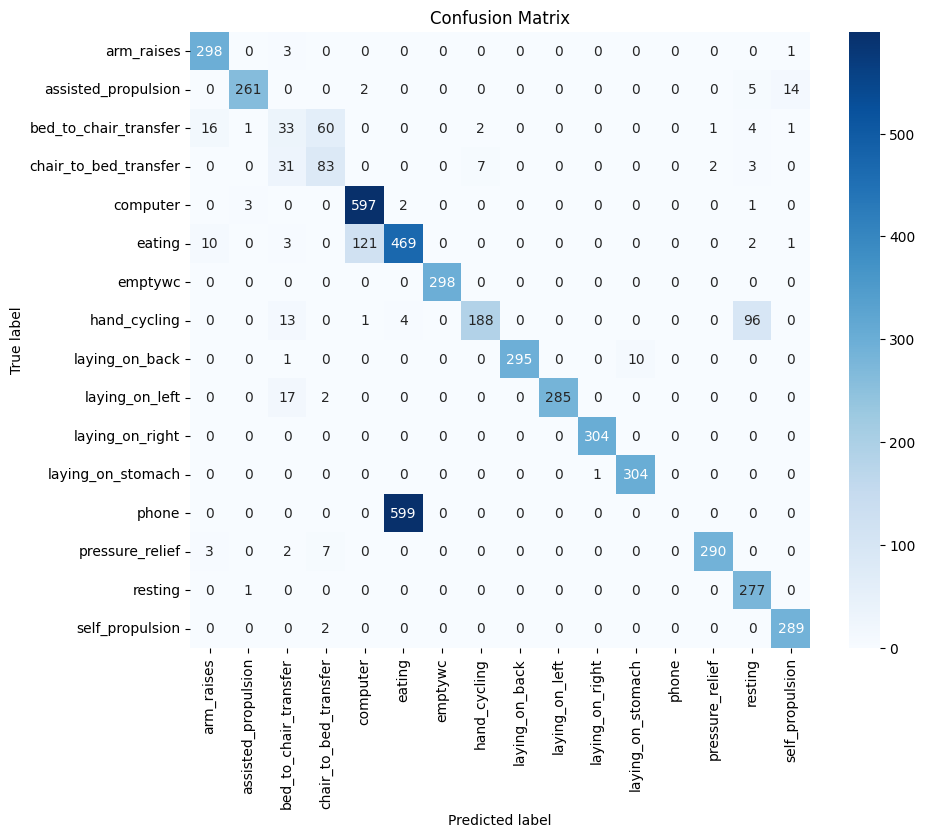

In [6]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predict
y_pred = bst.predict(dtest)
y_pred_labels = le.inverse_transform(y_pred.astype(int))

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_labels, target_names=le.classes_))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_labels, labels=le.classes_)
cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()